# Section 1: Business understanding
In this project I aim to investigate a Airbnb data set collected from Kaggle. The data set should allow us to get insights on the behaviour of the Seattle Airbnb scene. The insights are intended to be useful both for a customer's point of view, but also an Airbnb lister.

The three questions I have decided to focus on in this project are:

Question 1: Are there large seasonal variations in Seattle Airbnb pricing? Which weekdays are cheapest / most expensive?

Question 2: How strong is the correlation between review score and price paid?  Score / $ ratio

Question 3: What is my expected revenue with an airbnb listing?

In [48]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.dates as mdates

# Section 2: Data Understanding

In [49]:
# Read in data to separate dataframes
calendar = pd.read_csv('calendar.csv')
listings = pd.read_csv('listings.csv')
reviews = pd.read_csv('reviews.csv')

In [50]:
# View and start editing / formatting data frames
calendar.head()

,listing_id,date,available,price
0,241032,2016-01-04,t,$85.00
1,241032,2016-01-05,t,$85.00
2,241032,2016-01-06,f,NaN
3,241032,2016-01-07,f,NaN
4,241032,2016-01-08,f,NaN


We see that the calendar dataframe has several missing values (NaN), and the price is formatted with $. We also see that the available column only has the values "t" or "f" - these could be translated to 0 and 1 if needed.

# Missing values
Let us investigate which columns in the dataframe suffer from missing values. Methods to deal with these missing values are investigated later

In [51]:
calendar.isna().sum()

listing_id         0
date               0
available          0
price         459028
dtype: int64

Calendar) We see that the price column in the calendar has many missing values. 
This is logical, as there shouldnt be a price entered when the listing is not rented out. 
We need to be aware of implications this might have for further analysis and modelling.

In [52]:
listings.isna().sum()

id                                    0
listing_url                           0
scrape_id                             0
last_scraped                          0
name                                  0
                                   ... 
cancellation_policy                   0
require_guest_profile_picture         0
require_guest_phone_verification      0
calculated_host_listings_count        0
reviews_per_month                   627
Length: 92, dtype: int64

This is a large table, and not immediately clear which columns have many missing values

In [53]:
series = listings.isna().sum()

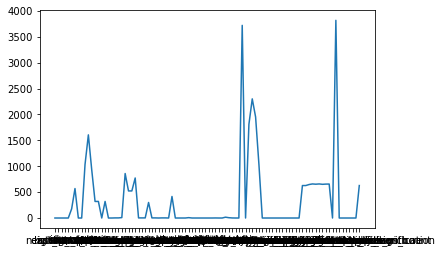

In [54]:
plt.plot(series)

In [55]:
relative = 100 * listings.isna().sum().sum() / listings.size

In [56]:
print('Relative amount of missing values in listings data frame is: '+ str(relative) +' %')

Relative amount of missing values in listings data frame is: 8.489250005693853 %


In [57]:
reviews.isna().sum()

listing_id        0
id                0
date              0
reviewer_id       0
reviewer_name     0
comments         18
dtype: int64

No issues in the reviews table, apart from some missing review comments

In [58]:
calendar['price']

0          $85.00
1          $85.00
2             NaN
3             NaN
4             NaN
            ...  
1393565       NaN
1393566       NaN
1393567       NaN
1393568       NaN
1393569       NaN
Name: price, Length: 1393570, dtype: object

I follow the strategy of only dealing with the missing values if found necessarry for the calculations I intend to do.
In this project I have not imputed any values, as I have not done any modelling efforts that would require this. 
This could be looked into.

# Section 3: Data Preparation

In [59]:
# Remove some of the number formatting,, and convert to numeric
calendar['price']=calendar['price'].str.replace('$','')
calendar['price']=calendar['price'].str.replace(',','')
calendar['price']=pd.to_numeric(calendar['price'])

In [60]:
calendar.dtypes

listing_id      int64
date           object
available      object
price         float64
dtype: object

It seems as the process above has succeeded transforming the price column

In [61]:
# For each date, calculate the average price, and the standard deviation. 
# the mean calculation does not include NaN's and as such, the calculations can proceed fine.
perdate = calendar.groupby('date')
mean_price = perdate['price'].mean()
number_days = mean_price.size
year_mean = mean_price.mean()
std_price = perdate['price'].std()

In [62]:
# See if we can get average price per weekday
calendar['date'] = pd.to_datetime(calendar['date'])
# translate date to a weekday, 0 = Monday, 6 = Sunday
calendar['week_day'] = calendar['date'].dt.weekday
weekdaymean = calendar.groupby('week_day')['price'].mean()
weekmean = weekdaymean.mean()

Question 2) Prep. To answer this we need to merge the listings and calendar data frames. For each listing, calculate the average price and the average score
For each id, calculate the average rental price from calendar df, add to a new df consisting of id, score and avg price

I put this in a function allowing for later reuse

In [67]:
def listing_average(listings, calendar):
    """"
    Input: listings and calendar dataframes
    Output: merged dataframe, with average price and average review score added per listing
    Merges on listing id, and calculates the averages per listing id
    """
    ids = listings['id'].unique()
    output = pd.DataFrame(columns=['id','avg_price','avg_review_score'])
    for i in ids:
        avg_price = calendar.loc[calendar['listing_id']==i]['price'].mean()
        review_score = listings.loc[listings['id']==i]['review_scores_value'].mean()
        # add i, avg_price, review_score as new entry to df
        output = output.append({'id': i, 'avg_price': avg_price, 'avg_review_score': review_score}, ignore_index=True)
    return output

In [68]:
output = listing_average(listings,calendar)

In [69]:
output.head()

,id,avg_price,avg_review_score
0,241032.0,85.000000,10.0
1,953595.0,170.931271,10.0
2,3308979.0,1301.818182,10.0
3,7421966.0,100.000000,NaN
4,278830.0,462.739726,9.0


# Section 5: Data analysis

# Question 1: Are there large seasonal variations in Seattle Airbnb pricing? Which weekdays are cheapest / most expensive?

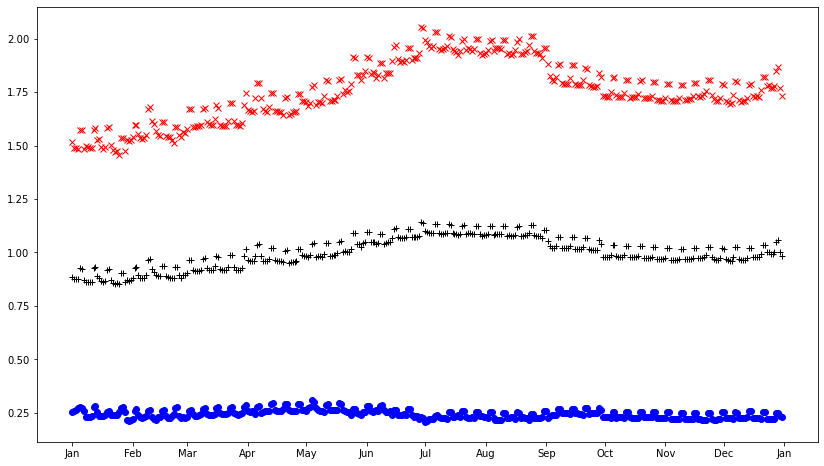

In [70]:
# this plot should answer the seasonal variations .. 
fig, ax = plt.subplots()
ax.plot(mean_price/year_mean,'k+')
ax.plot((mean_price + std_price)/year_mean, 'rx')
ax.plot((mean_price - std_price)/year_mean, 'bo')

# Below code is stolen
# Make ticks on occurrences of each month:
ax.xaxis.set_major_locator(mdates.MonthLocator())
# Get only the month to show in the x-axis:
ax.xaxis.set_major_formatter(mdates.DateFormatter('%b'))
# '%b' means month as locale’s abbreviated name

fig.set_size_inches(14, 8)

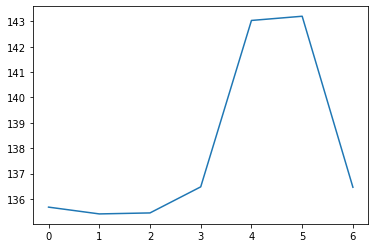

In [71]:
fig, ax = plt.subplots()
ax.plot(weekdaymean)

# Question 2: How strong is the correlation between review score and price paid? Score / Price paid ratio

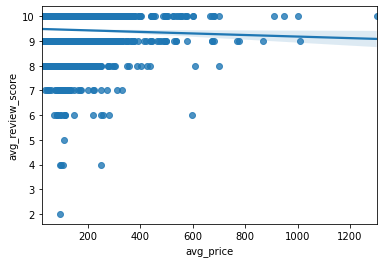

In [72]:
ax = sns.regplot(x="avg_price", y="avg_review_score", data=output)

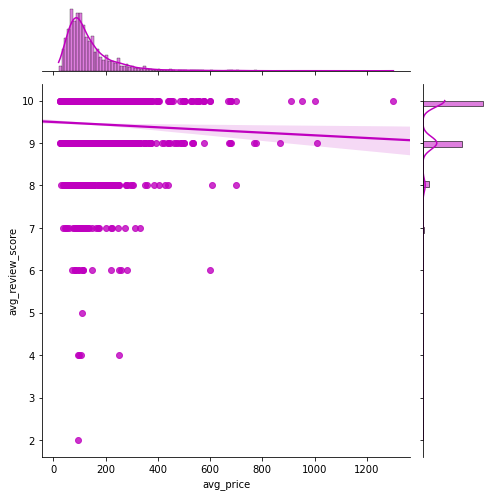

In [73]:
tips = sns.load_dataset("tips")
g = sns.jointplot(x="avg_price", y="avg_review_score", data=output,
                  kind="reg", truncate=False,
                  color="m", height=7)

# Question 3: What is my expected revenue with an airbnb listing?

In [74]:
taken = calendar.loc[calendar['available']=='t'].count()['available']
free = calendar.loc[calendar['available']=='f'].count()['available']
taken / (free + taken)

0.6706100160020666

In [75]:
# Average occupancy rate 67% .. what is average price for the nights when taken? 

In [76]:
calendar['price'].mean() 

137.94485855103355

In [77]:
calendar['price'].sum() / taken
# expected income per year is then:
calendar['price'].mean() * (taken / (free + taken)) * number_days

33765.129387113666